<a id="top"></a>

# 02 — Codificación **offline** a H5 (formato v2)

Convierte los *splits* CSV (`train/val/test`) ya preparados en **archivos H5** con codificación temporal. Es la vía recomendada cuando el preset activa `data.use_offline_spikes: true` y `data.encode_runtime: false`, porque **acelera la E/S** y fija exactamente los mismos eventos para todos los métodos.

**Qué hace este notebook**

- Localiza el fichero de tareas **según el preset**: usa `tasks_balanced.json` si `prep.use_balanced_tasks: true` **y** existe; si no, cae a `tasks.json` (se avisa en consola).
- Para cada *run* y *split*, lee el CSV correspondiente y **aplica la codificación temporal** (`rate` | `latency` | `raw`) con los parámetros del preset (`T`, `gain`, `img_w/img_h`, `to_gray`).
- Escribe H5 con **formato v2** auto-descriptivo y **nomenclatura estable** (incluye `encoder`, `T`, `gain`, `gray|rgb`, `W×H`).


---

## ✅ Prerrequisitos
- Haber generado los CSV con **uno** de estos cuadernos:
  - `01_DATA_QC_PREP.ipynb` (QC + *splits* sin balanceo), **o**
  - `01A_PREP_BALANCED.ipynb` (QC + *splits* y, si lo activas, `train_balanced.csv`).
- Estructura de datos (se admiten **múltiples vueltas** por circuito):
    - `data/raw/udacity/<circuito>/<vuelta>/{driving_log.csv, IMG/}`
    - `data/processed/<circuito>/{train.csv, val.csv, test.csv[, train_balanced.csv]}`
    - `data/processed/tasks.json[, tasks_balanced.json]`


**Salidas**
- Un H5 por combinación (`run`, `split`):
- `data/processed/<run>/<split>_<encoder>T<T>gain<g><gray|rgb><W>x<H>.h5`

> Convención: si `encoder != "rate"`, el sufijo se fija a `gain0`.

<a id="toc"></a>

## 🧭 Índice

- [1) Configuración de codificación (parámetros y rutas)](#sec-01)
- [2) Generación de H5 para todos los `RUNS × SPLITS`](#sec-02)
- [3) Inspección QC de un H5 (atributos, formas y proyección)](#sec-03)


<a id="sec-01"></a>
## 1) Configuración de la **codificación offline** a H5

**Objetivo**  
Dejar listos los parámetros de codificación temporal y las rutas base. Esta celda:

- Lee el **preset** (`fast|std|accurate`) desde `configs/presets.yaml`.
- Fija:
- `ENCODER` (`rate` | `latency` | `raw`)
- `T` y `GAIN` (solo afecta a `rate`)
- `SIZE = (W, H)` y `TO_GRAY`
- `SEED` (para reproducibilidad si la codificación usa estocasticidad)
- Detecta el fichero de tareas a usar (`tasks_balanced.json` o `tasks.json`) según el preset.
- Construye `RUNS` y `SPLITS = ["train","val","test"]`.

**Consejos**

- Puedes cambiar `PRESET = "..."` para probar distintas combinaciones (`T`, `gain`, gris/RGB).
- El bloque **“Helper multi-PRESET”** te permite lanzar **varios presets** seguidos sin duplicar la lógica.

[↑ Volver al índice](#top)

In [1]:
# =============================================================================
# 1) Imports & params (desde presets.yaml)
# =============================================================================
from pathlib import Path
import sys, json
import pandas as pd  # opcional, por si inspeccionas algo

# ---- STUBS para el linter (Pylance) ----
from typing import Optional
SAMPLE_OUT: Optional[Path] = None          # se asigna en la Celda 2
SAMPLE_OUTS: list[tuple[str, Optional[Path]]] = []  # se rellena en la Celda 2
# ----------------------------------------

# Raíz del repo y sys.path
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# APIs del proyecto
from src.utils import load_preset
from src.prep.encode_offline import encode_csv_to_h5

# --- Lee preset base ---
PRESET = "fast"  # fast | std | accurate (puedes cambiarlo)
CFG = load_preset(ROOT / "configs" / "presets.yaml", PRESET)

# --- Params robustos del preset ---
ENCODER = str(CFG["data"]["encoder"])
T       = int(CFG["data"]["T"])
GAIN    = float(CFG["data"]["gain"])
SIZE    = (int(CFG["model"]["img_w"]), int(CFG["model"]["img_h"]))  # (W, H)
TO_GRAY = bool(CFG["model"]["to_gray"])
SEED    = int(CFG["data"]["seed"])

# --- Rutas base ---
RAW_ROOT  = ROOT / "data" / "raw" / "udacity"
PROC_ROOT = ROOT / "data" / "processed"

# --- Selección de fichero de tasks según preset ---
USE_BALANCED = bool(CFG.get("prep", {}).get("use_balanced_tasks", False))
tasks_balanced_name = (CFG.get("prep", {}).get("tasks_balanced_file_name") or "tasks_balanced.json")
tasks_plain_name    = (CFG.get("prep", {}).get("tasks_file_name") or "tasks.json")

candidate = PROC_ROOT / (tasks_balanced_name if USE_BALANCED else tasks_plain_name)
if candidate.exists():
    TASKS_PATH = candidate
else:
    # Fallback sensato a tasks.json si el balanced no existe
    fallback = PROC_ROOT / tasks_plain_name
    if candidate != fallback:
        print(f"[WARN] No existe {candidate.name}; usando {fallback.name} en su lugar.")
    TASKS_PATH = fallback

TASKS  = json.loads(TASKS_PATH.read_text(encoding="utf-8"))
RUNS   = TASKS["tasks_order"]
SPLITS = ["train", "val", "test"]

# --- Echo de configuración efectiva ---
print(f"[PRESET={PRESET}] encoder={ENCODER} T={T} gain={GAIN} | size={SIZE} gray={TO_GRAY} | seed={SEED}")
print("Usando tasks:", TASKS_PATH.name, "| balanced:", USE_BALANCED)
print("RUNS:", RUNS)

# =============================================================================
# 1-bis) Helper multi-PRESET (opcional). No rompe el flujo single-PRESET.
# =============================================================================
EXTRA_PRESETS = []  # ["rate_t10_gray", "rate_t16_rgb", "latency_t16_gray"]

def _encode_for_preset(preset_name: str) -> dict:
    """
    Carga el preset dado y devuelve todo lo necesario para ejecutar el encode
    sin depender de variables globales de esta celda.
    """
    CFGp = load_preset(ROOT / "configs" / "presets.yaml", preset_name)

    ENCODERp = str(CFGp["data"]["encoder"])
    Tp       = int(CFGp["data"]["T"])
    GAINp    = float(CFGp["data"]["gain"])
    SIZEp    = (int(CFGp["model"]["img_w"]), int(CFGp["model"]["img_h"]))  # (W,H)
    TO_GRAYp = bool(CFGp["model"]["to_gray"])
    SEEDp    = int(CFGp["data"]["seed"])

    USE_BALANCEDp = bool(CFGp.get("prep", {}).get("use_balanced_tasks", False))
    tasks_balanced_name_p = (CFGp.get("prep", {}).get("tasks_balanced_file_name") or "tasks_balanced.json")
    tasks_plain_name_p    = (CFGp.get("prep", {}).get("tasks_file_name") or "tasks.json")

    candidate_p  = PROC_ROOT / (tasks_balanced_name_p if USE_BALANCEDp else tasks_plain_name_p)
    TASKS_PATHp  = candidate_p if candidate_p.exists() else (PROC_ROOT / tasks_plain_name_p)
    TASKSp       = json.loads(TASKS_PATHp.read_text(encoding="utf-8"))
    RUNSp        = TASKSp["tasks_order"]
    SPLITSp      = ["train", "val", "test"]

    return dict(
        ENCODER=ENCODERp, T=Tp, GAIN=GAINp, SIZE=SIZEp, TO_GRAY=TO_GRAYp, SEED=SEEDp,
        TASKS=TASKSp, TASKS_PATH=TASKS_PATHp, RUNS=RUNSp, SPLITS=SPLITSp, USE_BALANCED=USE_BALANCEDp
    )


[PRESET=fast] encoder=rate T=10 gain=0.5 | size=(200, 66) gray=True | seed=42
Usando tasks: tasks_balanced.json | balanced: True
RUNS: ['circuito1', 'circuito2']


<a id="sec-02"></a>
## 2) Generación de H5 (formato **v2**) para todos los RUNS × SPLITS

**Qué hace**

- Recorre cada `run` y `split`, comprueba la existencia de los CSV y llama a `encode_csv_to_h5(...)`.
- Escribe un H5 por salida con **nomenclatura determinista**:
    - `<split>_<encoder>T<T>gain<g><gray|rgb><W>x<H>.h5`
- Guarda en `SAMPLE_OUT` el **primer H5** generado para inspección rápida en la celda 3.
- Si indicas varios presets en `EXTRA_PRESETS`, repetirá el proceso para cada uno.

**Formato H5 v2**

- **Atributos** (metadatos del archivo):
- `version = 2`
- `encoder`, `T`, `gain`
- `size_wh = [W, H]`
- `to_gray`
- `channels` (1 ó 3)
- **Datasets**:
- `/spikes`:
  - gris → `(N, T, H, W)`
  - RGB  → `(N, T, C, H, W)`
  - tipo:
    - `rate`/`raw` → `uint8`
    - `latency` → `float32`
- `/steering` → `(N,)`
- `/filenames` → `(N,)` (rutas relativas para trazabilidad)

**Idempotencia y limpieza**

- **No hace falta borrar** H5 antiguos al cambiar parámetros: el **nombre de salida cambia** (no se pisan).
- Si quieres ahorrar espacio, elimina manualmente H5 viejos que no uses.
- Si `tasks_balanced.json` no existe pero el preset pide usarlo, se **avisa** y se cae a `tasks.json`.

**Errores típicos y solución**

- *“No existe CSV/H5 esperado”* → ejecuta antes `01A_PREP_BALANCED` (o `01_DATA_QC_PREP`) y revisa `tasks*.json`.
- *“Forma inesperada”* al entrenar → asegúrate de que `to_gray` y `W×H` del preset **coinciden** con los H5 generados.

[↑ Volver al índice](#top)


In [2]:
# =============================================================================
# 2) Generar H5 (uno o varios PRESETs)
# =============================================================================
# --- STUBS para el linter (si ejecutas esta celda suelta) ---
SAMPLE_OUTS = []   # <- stub para Pylance
SAMPLE_OUT = None  # <- stub para Pylance

from pathlib import Path
import json
from src.prep.encode_offline import encode_csv_to_h5

if "ROOT" not in globals():
    ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if "RAW_ROOT" not in globals():
    RAW_ROOT  = ROOT / "data" / "raw" / "udacity"
if "PROC_ROOT" not in globals():
    PROC_ROOT = ROOT / "data" / "processed"
if "PRESET" not in globals():
    PRESET = "fast"
if "EXTRA_PRESETS" not in globals():
    EXTRA_PRESETS = []

# --- Ejecuta encode para el preset principal y los extra (si los hay) ---
PRESETS_TO_RUN = [PRESET] + list(EXTRA_PRESETS)

for P in PRESETS_TO_RUN:
    info = _encode_for_preset(P)

    ENCODER = info["ENCODER"]; T = info["T"]; GAIN = info["GAIN"]
    SIZE = info["SIZE"]; TO_GRAY = info["TO_GRAY"]; SEED = info["SEED"]
    RUNS = info["RUNS"]; SPLITS = info["SPLITS"]

    print(f"\n=== PRESET={P} | encoder={ENCODER} T={T} gain={GAIN} size={SIZE} gray={TO_GRAY} seed={SEED} ===")
    print("Usando tasks:", info["TASKS_PATH"].name, "| balanced:", info["USE_BALANCED"])
    print("RUNS:", RUNS)

    color_tag = "gray" if TO_GRAY else "rgb"
    gain_tag  = GAIN if ENCODER == "rate" else 0
    W, H = SIZE
    SAMPLE_OUT = None

    for run in RUNS:
        base = RAW_ROOT / run
        outdir = PROC_ROOT / run
        outdir.mkdir(parents=True, exist_ok=True)
        assert base.exists(), f"No existe carpeta de imágenes: {base}"

        paths = info["TASKS"]["splits"][run]
        for split in SPLITS:
            csv = Path(paths[split])
            if not csv.is_absolute():
                csv = ROOT / csv
            assert csv.exists(), f"No existe CSV: {csv}"

            out = outdir / f"{split}_{ENCODER}_T{T}_gain{gain_tag}_{color_tag}_{W}x{H}.h5"
            encode_csv_to_h5(
                csv_df_or_path=csv, base_dir=base, out_path=out,
                encoder=ENCODER, T=T, gain=GAIN, size_wh=(W, H),
                to_gray=TO_GRAY, seed=SEED
            )
            print("OK:", out)
            if SAMPLE_OUT is None:
                SAMPLE_OUT = out

    SAMPLE_OUTS.append((P, SAMPLE_OUT))

print("\nHecho.")
for P, out in SAMPLE_OUTS:
    print(f"Ejemplo de salida [{P}]:", out)



=== PRESET=fast | encoder=rate T=10 gain=0.5 size=(200, 66) gray=True seed=42 ===
Usando tasks: tasks_balanced.json | balanced: True
RUNS: ['circuito1', 'circuito2']
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/val_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/test_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/train_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/val_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/test_rate_T10_gain0.5_gray_200x66.h5

Hecho.
Ejemplo de salida [fast]: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T10_gain0.5_gray_200x66.h5


<a id="sec-03"></a>
## 3) Inspección rápida del H5 generado (formato v2)

**Qué verifica esta celda**

- Abre `SAMPLE_OUT` y muestra:
- **Atributos** (comprueba `version=2`, `encoder`, `T`, `gain`, `size_wh`, `to_gray`, `channels`).
- **Datasets** disponibles y sus **formas/tipos**.
- Calcula y dibuja una **proyección acumulada** del primer ejemplo:
- gris: `sum` sobre `T` → `H×W`
- RGB: `sum` sobre `T` y `C` → `H×W`

**Cómo interpretarlo**

- En `rate/raw` (binario, `uint8`), la proyección refleja **densidad de actividad** por píxel.
- En `latency` (`float32`), revisa que los valores sigan la convención del codificador (p. ej., latencia/−1).

**Siguientes pasos**

- Si la inspección es correcta y tu preset pretende usar H5, asegúrate de tener:
```yaml
  data:
    use_offline_spikes: true
    encode_runtime: false
```

Después puedes pasar directamente a `03_TRAIN_CONTINUAL.ipynb`.

[↑ Volver al índice](#top)

Mostrando: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T10_gain0.5_gray_200x66.h5
Atributos:
 - T: 10
 - channels: 1
 - encoder: rate
 - gain: 0.5
 - size_wh: [200  66]
 - to_gray: 1
 - version: 2
Datasets: ['filenames', 'spikes', 'steering']
spikes: (294245, 10, 66, 200) uint8 | steering: (294245,) float32


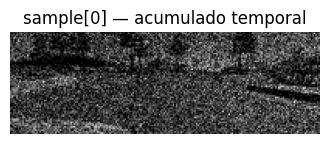

In [3]:
# =============================================================================
# 3) Inspección del H5 (formato oficial v2)
# =============================================================================
# --- STUBS para el linter (si ejecutas esta celda suelta) ---
SAMPLE_OUTS = globals().get("SAMPLE_OUTS", [])
SAMPLE_OUT = globals().get("SAMPLE_OUT", None)

from pathlib import Path
import h5py, numpy as np, matplotlib.pyplot as plt

if SAMPLE_OUT is None and SAMPLE_OUTS:
    SAMPLE_OUT = SAMPLE_OUTS[0][1]
if SAMPLE_OUT is None:
    raise RuntimeError("Ejecuta la Celda 2 primero para generar al menos un H5 (SAMPLE_OUT).")

print("Mostrando:", SAMPLE_OUT)

def _proj_img(x):
    # (T,H,W) -> acumula T; (T,C,H,W) -> acumula T y C
    if x.ndim == 2:
        return x
    if x.ndim == 3:
        return x.sum(axis=0)
    if x.ndim == 4:
        return x.sum(axis=(0,1))
    raise ValueError(x.shape)

with h5py.File(SAMPLE_OUT, "r") as h5:
    print("Atributos:")
    for k, v in h5.attrs.items():
        print(f" - {k}: {v}")
    print("Datasets:", list(h5.keys()))

    X = h5["spikes"]
    y = h5["steering"]
    print("spikes:", X.shape, X.dtype, "| steering:", y.shape, y.dtype)

    x0 = X[0]  # (T,H,W) o (T,C,H,W)
    acc = _proj_img(x0)

plt.figure(figsize=(4, 3))
plt.imshow(acc, cmap="gray")
plt.title("sample[0] — acumulado temporal")
plt.axis("off")
plt.show()
